In [31]:
import numpy as np
import pandas as pd

# Carregando o dataset e selecionando as colunas necessárias
dataset = pd.read_csv('../dataset/dados_pregao_lwsa3.csv')
colunas = ['data_pregao', 'preco_ultimo_negocio']
data = dataset[colunas].copy()  # Usando .copy() para evitar problemas de referência

# Convertendo a coluna de data corretamente usando .loc
data.loc[:, 'data_pregao'] = pd.to_datetime(data['data_pregao'])

# Definindo a coluna de data como índice
data.set_index('data_pregao', inplace=True)

test_data = None
train_data = None
# Selecionando os últimos 30 pregões
test_data = data.tail(30)  # Últimos 30 registros (pregões)
train_data = data.iloc[:-30]  # Restante dos dados para treino

# Extraindo os valores das séries de treino e teste
train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

# Exibindo o dataframe completo (opcional)
data


,preco_ultimo_negocio
data_pregao,
2020-02-06,20.60
2020-02-07,20.30
2020-02-10,20.20
2020-02-11,20.20
2020-02-12,21.92
...,...
2024-10-01,4.16
2024-10-02,4.19
2024-10-03,4.07


30 DIAS

In [32]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [33]:
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(sequence_length, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

predictions = model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/100


c:\Users\suporte\Documents\Workspace\pregao_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 466.8259
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 57.2093
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.1038
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18079.7793
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10965.5869
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 38645.3867
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1022.0462
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 118.7830
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 132.9210
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 115.1802
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 118.5094
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 127.8880
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 100.7967
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 108.6250
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Mean Squared Error (MSE): 0.0671384140451445
Root Mean Squared Error (RMSE): 0.259110814218829
Mean Absolute Percentage Error (MAPE): 4.705315443122382%


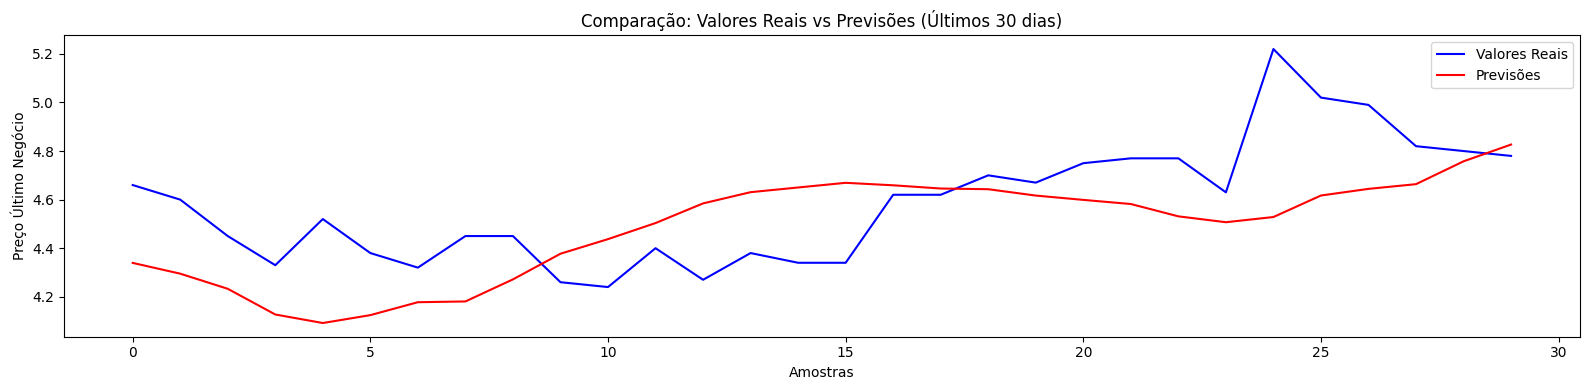

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraindo os últimos 30 dias do conjunto de treino
comparison_data = train_data.iloc[-60:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

# Criando sequências para o modelo prever
#sequence_length = 30  # Exemplo: sequências de 30 dias
X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

# Redimensionando para o formato de entrada esperado pelo LSTM
X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

# Realizando previsões para os últimos 90 dias
predictions = model.predict(X_test_sequences)

# Calculando as métricas MSE, RMSE e MAPE
mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Criando DataFrame para facilitar a comparação
results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

# Plotando a comparação entre os valores reais e as previsões
plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

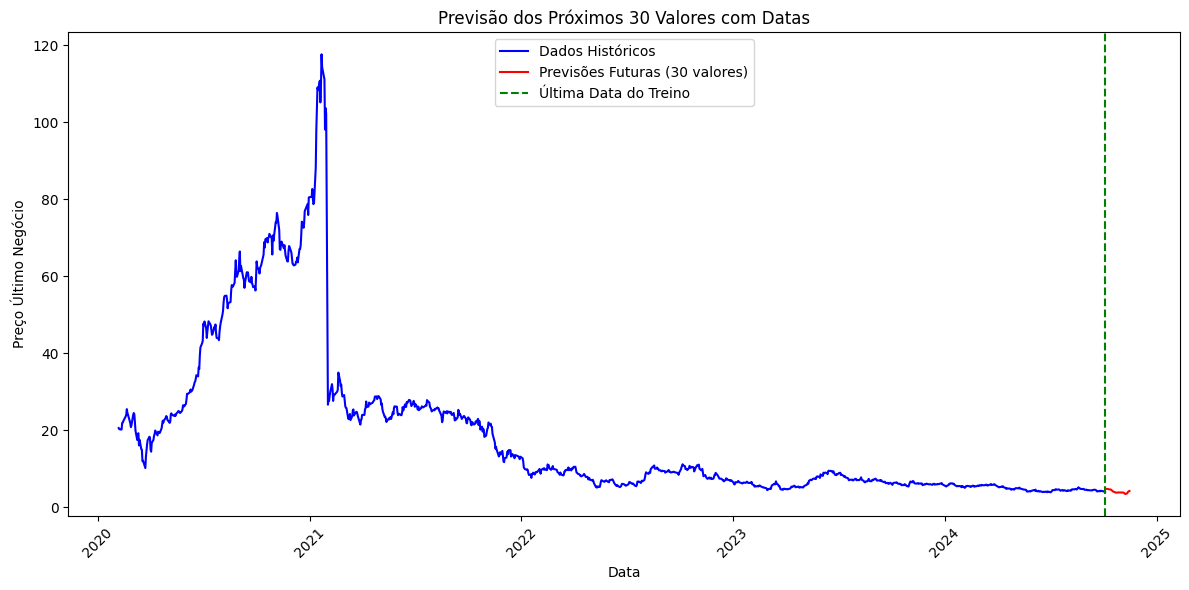

In [35]:
import matplotlib.pyplot as plt

last_sequence = train_data_values[-sequence_length:]  # Última sequência de treino
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(30):  # Prever os próximos 30 valores
    next_prediction = model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    # Atualizar a sequência atual para incluir a nova previsão
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

# Converter as previsões em um array unidimensional
future_predictions = np.array(future_predictions).flatten()

# Criar um DataFrame com as próximas 30 datas e os valores previstos
last_date = data.index[-1]  # Última data do conjunto de treino
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')  # Próximas 30 datas úteis

# Criar o DataFrame com as previsões e datas
future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

# Plotar os dados históricos e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (30 valores)', color='red')
plt.title('Previsão dos Próximos 30 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')  # Linha para a última data de treino
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

60 DIAS

In [36]:
test_data = None
train_data = None
# Selecionando os últimos 30 pregões
test_data = data.tail(60)
train_data = data.iloc[:-60]

# Extraindo os valores das séries de treino e teste
train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values


In [37]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [38]:
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

predictions = model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/100


c:\Users\suporte\Documents\Workspace\pregao_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3416.2490
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 486.7578
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 161.1720
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 115.3298
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 74.0591
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 56.5767
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 49.3651
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.7723
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 39.4860
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 43.7673
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 31.1032
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 60.6452
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 98.9965
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 109.0320
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Mean Squared Error (MSE): 0.09720566280809292
Root Mean Squared Error (RMSE): 0.3117782269628412
Mean Absolute Percentage Error (MAPE): 5.597665901674352%


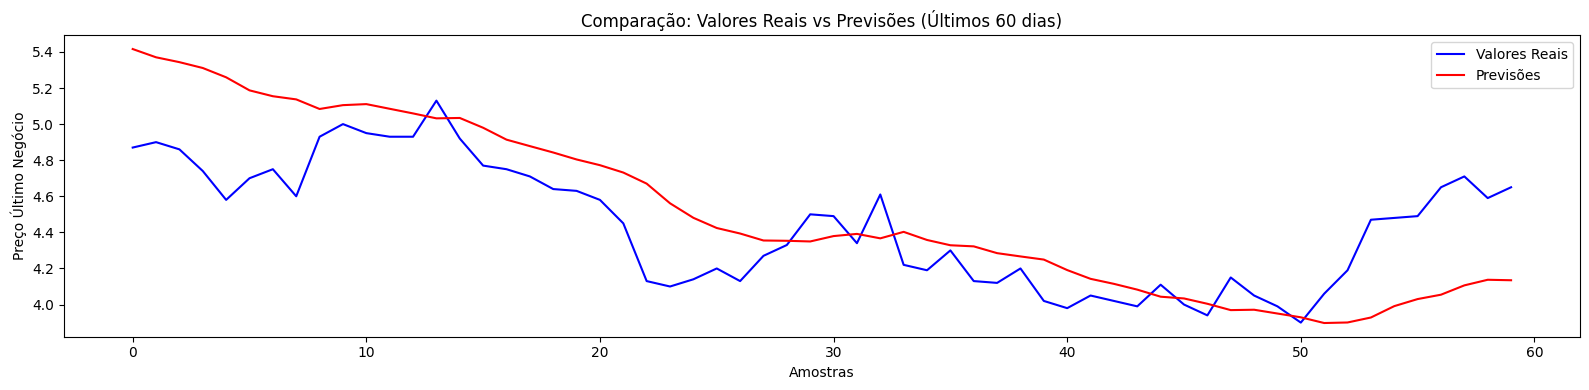

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraindo os últimos 90 dias do conjunto de treino
comparison_data = train_data.iloc[-90:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

# Criando sequências para o modelo prever
#sequence_length = 30  # Exemplo: sequências de 30 dias
X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

# Redimensionando para o formato de entrada esperado pelo LSTM
X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

# Realizando previsões para os últimos 90 dias
predictions = model.predict(X_test_sequences)

# Calculando as métricas MSE, RMSE e MAPE
mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Criando DataFrame para facilitar a comparação
results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

# Plotando a comparação entre os valores reais e as previsões
plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 60 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

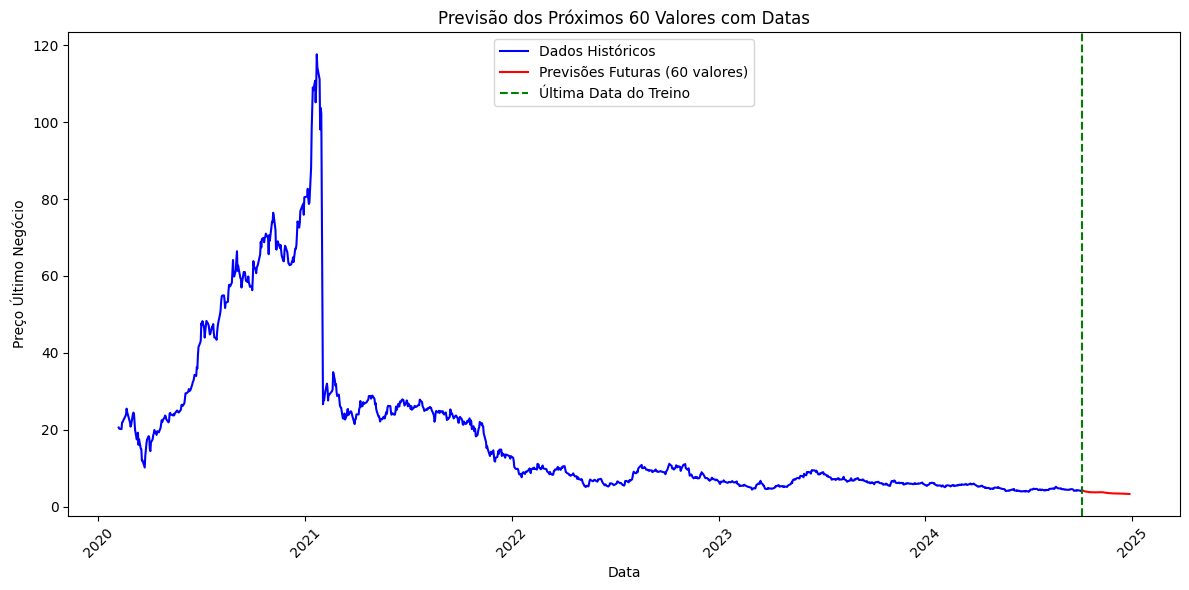

In [40]:
import matplotlib.pyplot as plt

last_sequence = train_data_values[-sequence_length:]  # Última sequência de treino
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(60):  # Prever os próximos 30 valores
    next_prediction = model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    # Atualizar a sequência atual para incluir a nova previsão
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

# Converter as previsões em um array unidimensional
future_predictions = np.array(future_predictions).flatten()

# Criar um DataFrame com as próximas 30 datas e os valores previstos
last_date = data.index[-1]  # Última data do conjunto de treino
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='B')  # Próximas 30 datas úteis

# Criar o DataFrame com as previsões e datas
future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

# Plotar os dados históricos e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (60 valores)', color='red')
plt.title('Previsão dos Próximos 60 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')  # Linha para a última data de treino
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

90 DIAS

In [41]:
test_data = None
train_data = None
# Selecionando os últimos 30 pregões
test_data = data.tail(90)
train_data = data.iloc[:-90]

# Extraindo os valores das séries de treino e teste
train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values


In [42]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  

In [43]:
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

predictions = model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/100


c:\Users\suporte\Documents\Workspace\pregao_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 303.4401
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 43.6018
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 50.2068
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 64.2163
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 36.2025
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 99.3239
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 121.7814
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 39.0676
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 42.2841
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 16.3377
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.2074
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.0427
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.1612
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5776
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Mean Squared Error (MSE): 0.0749149980554259
Root Mean Squared Error (RMSE): 0.27370604314743563
Mean Absolute Percentage Error (MAPE): 4.57629369169954%


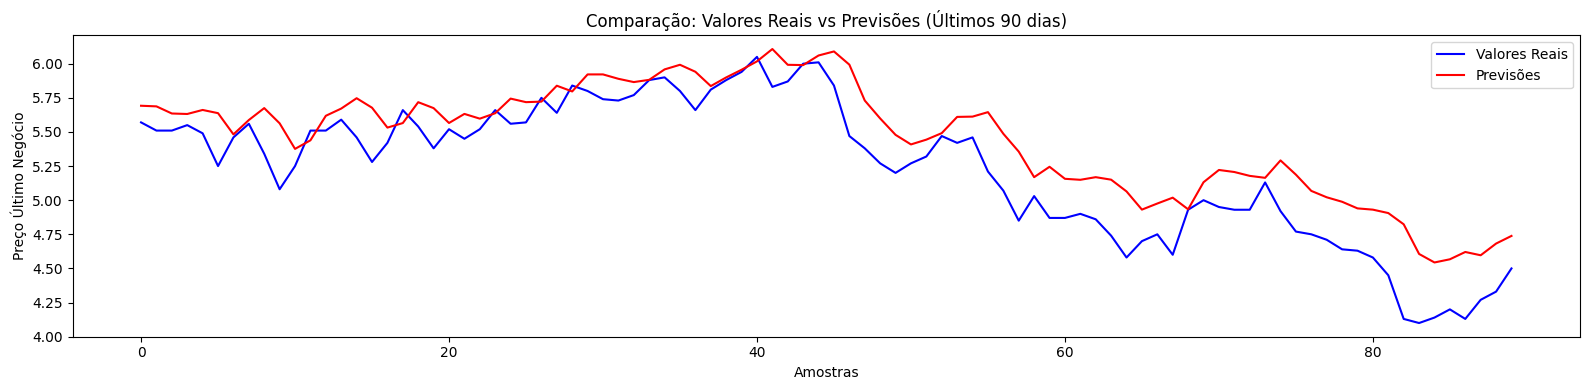

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraindo os últimos 90 dias do conjunto de treino
comparison_data = train_data.iloc[-120:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

# Criando sequências para o modelo prever
#sequence_length = 30  # Exemplo: sequências de 30 dias
X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

# Redimensionando para o formato de entrada esperado pelo LSTM
X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

# Realizando previsões para os últimos 90 dias
predictions = model.predict(X_test_sequences)

# Calculando as métricas MSE, RMSE e MAPE
mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Criando DataFrame para facilitar a comparação
results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

# Plotando a comparação entre os valores reais e as previsões
plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 90 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

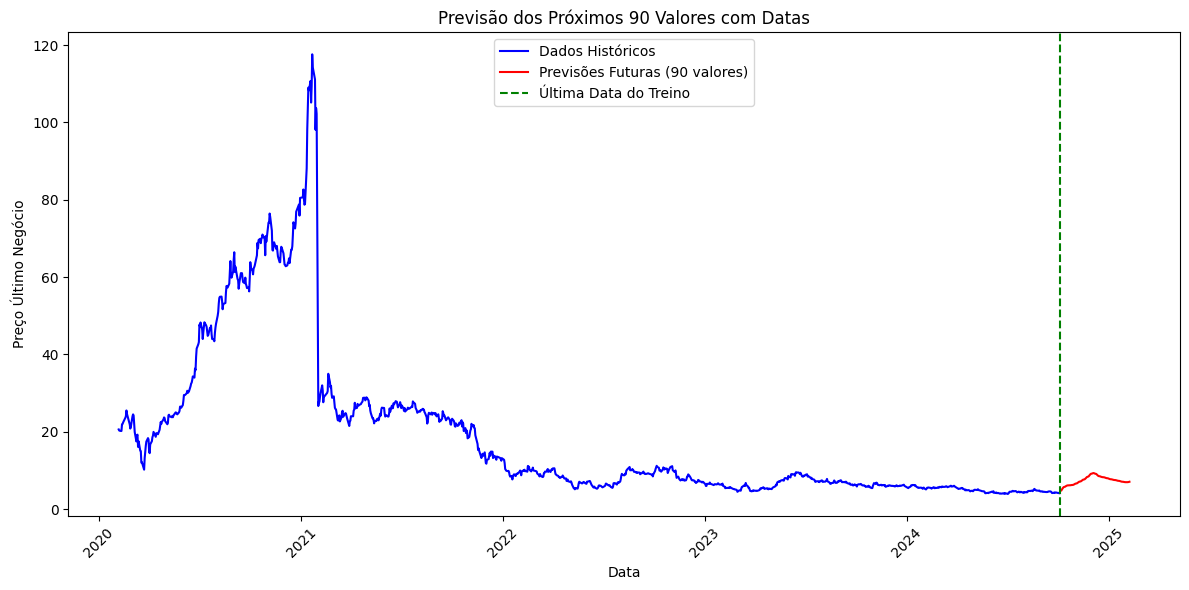

In [45]:
import matplotlib.pyplot as plt

last_sequence = train_data_values[-sequence_length:]  # Última sequência de treino
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(90):  # Prever os próximos 30 valores
    next_prediction = model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    # Atualizar a sequência atual para incluir a nova previsão
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

# Converter as previsões em um array unidimensional
future_predictions = np.array(future_predictions).flatten()

# Criar um DataFrame com as próximas 30 datas e os valores previstos
last_date = data.index[-1]  # Última data do conjunto de treino
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')  # Próximas 30 datas úteis

# Criar o DataFrame com as previsões e datas
future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

# Plotar os dados históricos e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (90 valores)', color='red')
plt.title('Previsão dos Próximos 90 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')  # Linha para a última data de treino
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()